In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
import math

In [2]:
# updated for solving MPC with TES task to use TES all the time

def chargetime(time): # charge = 1, discharge = -1
    xp = [0, 7.999, 8, 25]
    fp = [1,1,0,0]
    f = interpolate.interp1d(xp, fp, "linear")
    return f(time)

def dischargetime(time): # charge = 1, discharge = -1
    xp = [0, 8.999, 9, 17.999, 18, 25]
    fp = [0,0,-1,-1,0,0]
    f = interpolate.interp1d(xp, fp, "linear")
    return f(time)

# def chargetime(time): # charge = 1, discharge = -1
#     xp = [0, 7.999, 8, 25]
#     fp = [1,1,0,0]
#     f = interpolate.interp1d(xp, fp, "linear")
#     return f(time)

# def dischargetime(time): # charge = 1, discharge = -1
#     xp = [0, 13.999, 14, 17.999, 18, 25]
#     fp = [0,0,-1,-1,0,0]
#     f = interpolate.interp1d(xp, fp, "linear")
#     return f(time)

In [3]:
# PRICES FOR ELECTRICITY
def price(time, type_price='individual_3'):
    if type_price == 'individual_2': 
        # индивидуальный тариф 2ставочный
        xp = [0, 7.999, 8 , 23.999, 24, 25]
        fp = [2.29, 2.29, 6.18, 6.18, 2.29, 2.29]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'individual_3': 
        # индивидуальный тариф 3ставочный
        xp = [0, 7.999, 8 , 10.999, 11, 17.999, 18, 21.999, 22, 23.999, 24, 25]
        fp = [2.29, 2.29, 7, 7, 5.38, 5.38, 7, 7, 5.38, 5.38, 2.29, 2.29]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'commercial_1':
        # коммерческий тариф 4к
        xp = [0, 0.999, 1, 1.999, 2, 2.999, 3, 3.999, 4, 4.999, 5, 5.999, 6, 6.999, 7, 7.999, 8, 8.999, 9, 9.999, 10, 10.999, 11, 11.999, 12, 12.999, 13, 13.999, 14, 14.999, 15, 15.999, 16, 16.999, 17, 17.999, 18, 18.999, 19, 19.999, 20, 20.999, 21, 21.999, 22, 22.999, 23, 23.999, 24, 24.999]
        fp = [4.41704, 4.41704, 4.25404, 4.25404, 4.14436, 4.14436, 4.05468, 4.05468, 4.01459, 4.01459, 4.02631, 4.02631, 4.16135, 4.16135, 4.24251, 4.24251, 4.49976, 4.49976, 4.59363, 4.59363, 4.77394, 4.77394, 4.80014, 4.80014, 4.78849, 4.78849, 4.75757, 4.75757, 4.77814, 4.77814, 4.79783, 4.79783, 4.7674, 4.7674, 4.73724, 4.73724, 4.72584, 4.72584, 4.73167, 4.73167, 4.73894, 4.73894, 4.7544, 4.7544, 4.75318, 4.75318, 4.61478, 4.61478, 4.41704, 4.41704]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'commercial_2':
        # коммерческий тариф 2к
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [0, 0, 1, 2, 3, 4, 4, 3, 3]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)

In [4]:
# OCCUPANCY PROFILE
def occup(time):
    xp = [0, 8.9, 9, 12, 12.1, 15, 15.1, 18, 18.1]
    fp = [0, 0,   20,20, 30,   30, 10,    10,  0]
    
    n_hum     = np.interp(time, xp, fp)
    part      = 1. / 10.
    noise_div = part * n_hum
#     return n_hum + np.int64(np.random.normal(loc = 0.0, scale=noise_div))
    return n_hum

In [5]:
# TEMPERATURE EXAMPLES
def outtemp_example(time, day='B'):
    # https://msk.nuipogoda.ru/25-июля-2018
    if day == 'A': 
        # зимний день 26.02.2018 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [-17, -19, -19, -18, -16, -14, -15, -19, -20]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'B':
        # летний день 25.07.2018 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [19, 17, 18, 20, 25, 23, 21, 19, 18]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'C':
        # осенний день 10.10.2015 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [0, 0, 1, 2, 3, 4, 4, 3, 3]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'D':
        # весенний день 20.03.2014 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [-5, -7, -9, -5, -4, -4, -3, -5, -8]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)

In [6]:
# DIFFERENT TES PARAMETERS FUNCTION

# ICE

# Heat of ice melting
L_ice = 333000 #J/kg 

# Heat capacity of ice 
Cp_ice = 2100 #J/kg*K 
ro_ice = 900 #kg/m3
T_ice_melting = 0 #C


# WATER

# Heat capacity of water 
Cp_water = 4200 #J/kg*K 
ro_water = 1000 #kg/m3
T_water_melting = 0 #C

# PCM1 - K2HPO4(H2O)6

# Heat of pcm melting
L_pcm1 = 108000 #J/kg 

# Heat capacity of pcm 
Cp_pcm_fluid1 = 950 #J/kg*K 
Cp_pcm_solid1 = 950 #J/kg*K # !CHECK!

# Density for pcm
ro_pcm1 = 1750 #kg/m3 

# Melting temperature
T_pcm_melting1 = 14 #C


# PCM2 - PCM Products Salt hydrate S13

# Heat of pcm melting
L_pcm2 = 160000 #J/kg 

# Heat capacity of pcm 
Cp_pcm_fluid2 = 1900 #J/kg*K 
Cp_pcm_solid2 = 1900 #J/kg*K # !CHECK!

# Density for pcm
ro_pcm2 = 1515 #kg/m3 

# Melting temperature
T_pcm_melting2 = 13 #C


# PRICES FOR 1 KG
def prices_tes(tes_type):
    
    price_water = 5 # rub/kg
    price_ice = 5 # rub/kg
    price_pcm1 = 91.5 # rub/kg
    price_pcm2 = 170 # rub/kg
    
    if tes_type == 'water':
        return (price_water)
    elif tes_type == 'ice':
        return (price_ice)
    elif tes_type == 'pcm1':
        return (price_pcm1)
    elif tes_type == 'pcm2':
        return (price_pcm2)

# TES VOLUMES

tes_height = 1 #m
tes_radius = 0.25 #m



# TES MELT TEMPS
def melt_temp_tes(tes_type):
        
    if tes_type == 'water':
        return T_water_melting
    elif tes_type == 'ice':
        return T_ice_melting
    elif tes_type == 'pcm1':
        return T_pcm_melting1
    elif tes_type == 'pcm2':
        return T_pcm_melting2



def tes_mass(tes_type, tes_height, tes_radius):
    V_total = tes_height*(tes_radius**2)*np.pi

    # WATER/ICE

    N_pipes_water = 4 # heat exchange pipes inside TES
    d_pipe = 0.008 # m, external pipe diameter

    V_dead_water = np.pi*(d_pipe**2)/4*(2*tes_height*N_pipes_water)

    V_free_water = V_total - V_dead_water

    m_water = ro_ice*V_free_water
    m_ice = ro_ice*V_free_water

    # PCM

    N_pipes_pcm = 2*N_pipes_water # heat exchange pipes inside TES

    V_dead_pcm = np.pi*(d_pipe**2)/4*(2*tes_radius*N_pipes_pcm)

    V_free_pcm = V_total - V_dead_pcm

    m_pcm1 = ro_pcm1*V_free_pcm
    m_pcm2 = ro_pcm2*V_free_pcm
    
    if tes_type == 'water':
        return (m_water)
    elif tes_type == 'ice':
        return (m_ice)
    elif tes_type == 'pcm1':
        return (m_pcm1)
    elif tes_type == 'pcm2':
        return (m_pcm2)


def tes_temp(tes_height, tes_radius, charge, tes_type, T_tes_initial=16):
    
    # calculating the coefficients/constants
    # PIPES INSIDE TES AND (FREE AND DEAD) VOLUME ARE DIFFERENT
    
#     #kostyl
#     T_out = 20

    m_water = tes_mass(tes_type, tes_height, tes_radius)
    m_ice = tes_mass(tes_type, tes_height, tes_radius)
    m_pcm1 = tes_mass(tes_type, tes_height, tes_radius)
    m_pcm2 = tes_mass(tes_type, tes_height, tes_radius)


    if tes_type == 'water':
        
        if charge < m_water*Cp_water*(T_tes_initial - T_water_melting):
            T_tes_next = T_tes_initial - charge/m_water/Cp_water
        
        elif charge >= m_water*Cp_water*(T_tes_initial - T_water_melting):
            T_tes_next = T_water_melting
        
        if charge > m_water*Cp_water*(T_tes_initial - T_water_melting) + m_water*L_ice:
            diff = charge - m_water*Cp_water*(T_tes_initial - T_water_melting) + m_water*L_ice
            T_tes_next = T_water_melting - diff/m_water/Cp_ice
            
    if tes_type == 'ice':
        
        if charge < m_ice*Cp_water*(T_tes_initial - T_ice_melting):
            T_tes_next = T_tes_initial - charge/m_ice/Cp_water
        
        elif charge >= m_ice*Cp_water*(T_tes_initial - T_ice_melting):
            T_tes_next = T_ice_melting
        
        if charge > m_water*Cp_water*(T_tes_initial - T_ice_melting) + m_ice*L_ice:
            diff = charge - m_ice*Cp_water*(T_tes_initial - T_ice_melting) + m_ice*L_ice
            T_tes_next = T_ice_melting - diff/m_ice/Cp_ice
            
    if tes_type == 'pcm1':
        
        if charge < m_pcm1*Cp_pcm_fluid1*(T_tes_initial - T_pcm_melting1):
            T_tes_next = T_tes_initial - charge/m_pcm1/Cp_pcm_fluid1
        
        elif charge >= m_pcm1*Cp_pcm_fluid1*(T_tes_initial - T_pcm_melting1):
            T_tes_next = T_pcm_melting1
        
        if charge > m_pcm1*Cp_pcm_fluid1*(T_tes_initial - T_pcm_melting1) + m_pcm1*L_pcm1:
            diff = charge - m_pcm1*Cp_pcm_fluid1*(T_tes_initial - T_pcm_melting1) + m_pcm1*L_pcm1
            T_tes_next = T_pcm_melting1 - diff/m_pcm1/Cp_pcm_solid1
            
    if tes_type == 'pcm2':
        
        if charge < m_pcm2*Cp_pcm_fluid2*(T_tes_initial - T_pcm_melting2):
            T_tes_next = T_tes_initial - charge/m_pcm2/Cp_pcm_fluid2
        
        elif charge >= m_pcm2*Cp_pcm_fluid2*(T_tes_initial - T_pcm_melting2):
            T_tes_next = T_pcm_melting2
        
        if charge > m_pcm2*Cp_pcm_fluid2*(T_tes_initial - T_pcm_melting2) + m_pcm2*L_pcm2:
            diff = charge - m_pcm2*Cp_pcm_fluid2*(T_tes_initial - T_pcm_melting2) + m_pcm2*L_pcm2
            T_tes_next = T_pcm_melting2 - diff/m_pcm2/Cp_pcm_solid2
            
    if charge == 0:
        
        T_tes_next = T_tes_initial
    
    return T_tes_next # J/s

In [7]:
tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES


# INPUT DATA

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')


1440.0


In [8]:
url = 'https://raw.githubusercontent.com/asisakov/Thesis/master/moscow_T_2019.csv'

In [9]:
data_moscow = pd.read_csv(url, sep=';', header=1)

In [10]:
data_moscow

,Время в Москве,T
0,31.10.2019 21:00,-3.1
1,31.10.2019 18:00,-2.5
2,31.10.2019 15:00,-2.2
3,31.10.2019 12:00,-2.6
4,31.10.2019 09:00,-3.2
5,31.10.2019 06:00,-3.4
6,31.10.2019 03:00,-3.1
7,31.10.2019 00:00,-3.1
8,30.10.2019 21:00,-2.1
9,30.10.2019 18:00,-1.8


In [11]:
data_moscow.columns

Index(['Время в Москве', 'T'], dtype='object')

In [12]:
diction = {data_moscow.columns[0]: '01.11.2019 00:00', data_moscow.columns[1]: -3.9}

In [13]:
row_df = pd.DataFrame(data=diction, index=data_moscow.columns)
row_df = row_df.drop('T')
data_moscow = pd.concat([row_df, data_moscow], ignore_index=True)

In [14]:
data_moscow.iloc[-9:,:]

,Время в Москве,T
1704,02.04.2019 00:00,0.4
1705,01.04.2019 21:00,1.4
1706,01.04.2019 18:00,2.3
1707,01.04.2019 15:00,3.5
1708,01.04.2019 12:00,3.8
1709,01.04.2019 09:00,4.3
1710,01.04.2019 06:00,3.6
1711,01.04.2019 03:00,5.9
1712,01.04.2019 00:00,8.3


In [30]:
def find_data_temp(data, day, time):
    if day > 1:
        fpdata = np.array(data.iloc[-8*(day)-1:-8*(day-1),1])
    else:
        fpdata = np.array(data.iloc[-9:,1])
#     fp = []
#     for i in range
#     xp = [0, 3, 6 , 9, 12, 15, 18, 21, 24.1]
    xp = [24.2, 21, 18, 15, 12, 9, 6, 3, 0]
#     fp = [-17, -19, -19, -18, -16, -14, -15, -19, -20]
    f = interpolate.interp1d(xp, fpdata, "cubic")
    return f(time)

In [16]:
day = 1
time=24
find_data_temp(data_moscow, day, time)    

array(0.4853005)

In [48]:
def tes_using_day(tau, tes_type, RUN_RESULTS, day_data=1, max_iter=100, dayzz='example B', weather_data=data_moscow, print_graphs = False, print_iters = False, print_result = False):

    tau = tau #seconds
    time_t = np.arange(0,24,tau/3600)
    # time_t = []
    N = 24*3600 / tau
#     print(N)
    N = round(N)
    # for i in range(N):
    #     time_t.append(i*tau / 3600)
    prices_t = price(time_t, type_price='commercial_1')
    COP = 3
    C_out = 1005 # J/(kg K)
    C_in = 1005 # J/(kg K)
    m_air = 340 # kg
    m_wall = 11520/2 #kg
    C_wall = 1500 # J/(kg K)
    pa1 = tau/(m_air*C_in)
    h = 5 # m
    b = 10 # m
    k = 0.183 
    pa2 = h*b*k
    alpha_int = 8.7 # W/ m K
    S = 60 # m^2
    pa3 = 0.5 * alpha_int * h * (S / b + b)
    M_met = 120 # W
    T_vent = 21 # ^oC
    a_inf = 0.02 / 3600
    pa4 = a_inf * m_air * C_out
    M_light = 20 # W
    N_light = 15
    W_light = M_light * N_light
    L_evap = 333000 # W/kg
    M_moist = 0.000021 # kg/s
    pa5 = M_met - L_evap * M_moist
    pw1 = tau/(m_wall*C_wall)
    pn1 = tau/m_air
    pn2 = a_inf * m_air
    k_CO2 = 0.038 * 4 # g / s # medium work
    ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
    T_output = 17 # outer air temperature after TES
    
#     comp_to_work_MPC_inertia = 120000 #KOSTYL dlya ТЕСТА
#     comp_to_work_MPC_inertia = 112500 #KOSTYL dlya зарядки
    comp_to_work_MPC_inertia = 140000 #KOSTYL dlya зарядки
    
    REGULATOR = 45 # KOSTYL dlya снижения W_ch


    # INPUT DATA

    N_oc = occup(time_t)
    if dayzz == 'example B':
        T_out = outtemp_example(time_t, day='B')
    else:
        T_out = find_data_temp(weather_data, day_data, time_t)

    # TES INPUTS

    T_tes_initial = 16
    tes_type = tes_type # choose: 'water', 'ice', 'pcm1', 'pcm2'
    tes_height = 1 #m
    tes_radius = 0.5 #m

    # INITIAL PARAMETERS
    error = 1000

    P_c = 0 * time_t
    P_f = 0 * time_t
    charge_out = 0 * time_t

    P_c_prev = []
    P_f_prev = []
    charge_out_prev = []

    schetchik = 0    

    error = 1000
    cost_prev = 1000
    # COEFFICIENTS

    while schetchik <= max_iter and error > 0.000000001:

        W_HVAC = []
        W_dis = []
        W_ch = []
        Q = []

        Q.append(0.55 / 100 * P_f[0])
        W_HVAC.append(0)
        W_dis.append(0)
        W_ch.append(chargetime(time_t[0]) * W_HVAC[0])

    #     W_dis.append(0)
    #     W_ch.append(0)

        T_room = []
        T_wall = []
        n_CO2 = []
        E_tes = []
        T_tes = []
    #     T_room.append(24)
    #     T_wall.append(19)
    #     n_CO2.append(800)
    #     E_tes.append(0)

        T_room.append(19.8)
        T_wall.append(19)
        n_CO2.append(400)
        E_tes.append(0)
        T_tes.append(T_tes_initial)


        comp_to_work = 0

        fan_to_work = 0
        
        charge_out_collected = 0

        for i in range(N-1):

            Q.append(0.55 / 100 * P_f[i+1])

            W_HVAC.append(P_c[i+1] * COP)

            if E_tes[i] > 0:
                W_dis.append(-dischargetime(time_t[i+1])*1420/40*P_f[i+1]) # KOSTYL
            else:
                W_dis.append(0)
            
            W_ch.append(chargetime(time_t[i+1]) * W_HVAC[i+1]*((T_tes[i]+REGULATOR)/(T_tes_initial+REGULATOR)) + charge_out[i+1])

    #         W_dis.append(0)
    #         W_ch.append(0)

            comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
                            C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec

            fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air

            if 0 < time_t[i] < 8: 
                W_HVAC[i+1] = 0
            else:
                W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]

#             W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]

            T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                             + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

            T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

            n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))


            E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))

            if 0 < E_tes[i+1] < tau*W_dis[i+1]:
                W_dis[i+1] = E_tes[i+1] / tau
            elif E_tes[i+1] <= 0:
                W_dis[i+1] = 0
                E_tes[i+1] = 0

            T_tes.append(tes_temp(tes_height, tes_radius, E_tes[i], tes_type, T_tes_initial))

    #         if i % 100 == 5:
    #             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])
            charge_out_collected += charge_out[i]

        energy_consumed = 0
        cost = 0
        loss_T = 0
        loss_CO2 = 0

        P_c_prev = []
        P_f_prev = []
        charge_out_prev = []

        kek = 'Iteration '+ str(schetchik + 1)
        ventu = 'Ventilation rate, ' + kek
        refru = 'Refrigeration rate, ' + kek

    #     plt.figure(figsize=(5,5))
    #     plt.plot(time_t, P_f, color='blue', alpha=0.8, linewidth=1, label='Model')
    #     plt.title(ventu)
    #     plt.ylabel('%')
    #     plt.legend()
    #     plt.show

    #     plt.figure(figsize=(5,5))
    #     plt.plot(time_t, P_c, color='blue', alpha=0.8, linewidth=1, label='Model')
    #     plt.title(refru)
    #     plt.ylabel('W')
    #     plt.legend()
    #     plt.show

        comp_working = 0

        for i in range(len(T_room)):

            energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000


            cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
            P_c_prev.append(P_c[i])
            P_f_prev.append(P_f[i])
            charge_out_prev.append(charge_out[i])
            if T_room[i] > 24:
                loss_T += (T_room[i] - 24) * tau
            
            P_c[i] = 0

        for i in range(len(T_room)):
            
            
            if 0 < time_t[i] < 8:
                if T_out[i] < T_tes[i] - 4:
                    charge_out[i] = min(C_out * Q[i] * (T_tes[i] - T_out[i]), 4500)
                    charge_out[i] = max(charge_out[i],0)
                    P_f[i] = 40
                if comp_working < comp_to_work_MPC_inertia - charge_out_collected/COP:
                    P_c[i-1] = 500
                    P_c[i-1] = max(P_c[i-1],0)
                    comp_working += P_c[i-1]

            if 9 < time_t[i] < 18:
                P_c[i] = 0
                P_c[i-1] = 0
                P_c[i-2] = 0

            if 9 < time_t[i] < 18:
                if T_room[i] > 24:
                    P_f[i-1] += 10
                    P_f[i-1] = min(P_f[i-1], 40)
                    break
                if T_room[i] < 23.8:
                    P_f[i-1] -= 10
                    P_f[i-1] = max(P_f[i-1],0)
                if T_room[i] < 23:
                    P_f[i-2] -= 10
                    P_f[i-2] = max(P_f[i-2],0)

    #         if 9 < time_t[i] < 18:
    #             P_f[i] = 40     
        
        
#         comp_working = 0

#         for i in range(len(T_room)):

#             energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000


#             cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
#             P_c_prev.append(P_c[i])
#             P_f_prev.append(P_f[i])
#             charge_out_prev.append(charge_out[i])
            
#             if T_room[i] > 24:
#                 P_c[i-1] += 500
#                 P_c[i-1] = min(P_c[i-1],1500)
#                 P_c[i] += 500
#                 P_c[i] = min(P_c[i],1500)
#                 loss_T += (T_room[i] - 24) * tau
#             if T_room[i] < 23:
#                 P_c[i-1] -= 500
#                 P_c[i-1] = max(P_c[i-1],0)
#             if T_out[i] > T_tes[i] - 4:    
#                 if 0 < time_t[i] < 8:
#                     if comp_working < comp_to_work_MPC_inertia - charge_out_collected:
# #                     if comp_working < comp_to_work*1.05 - charge_out_collected:
#                         P_c[i-1] = 1000
#                         P_c[i-1] = max(P_c[i-1],0)
#                         comp_working += P_c[i-1]

#                     else:
#                         P_c[i-1] = 0
                        
#             else:
#                 if 0 < time_t[i] < 8:
#                     charge_out[i] = min(C_out * Q[i] * (T_tes[i] - T_out[i]), 4500)
#                     charge_out[i] = max(charge_out[i],0)
#                     P_f[i] = 20
                    
#             if 9 < time_t[i] < 18:
#                 P_c[i] = 0
#                 P_c[i-1] = 0
#                 P_c[i-2] = 0

#             if T_room[i] < T_wall[i] + 0.5:
#                     P_c[i-1] = 0

#             if 9 < time_t[i] < 18:
#                 if T_room[i] > 24:
#                     P_f[i-1] += 10
#                     P_f[i-1] = min(P_f[i-1], 40)
#                 if T_room[i] < 23.5:
#                     P_f[i-1] -= 10
#                     P_f[i-1] = max(P_f[i-1],0)
#                 if T_room[i] < 23:
#                     P_f[i-2] -= 10
#                     P_f[i-2] = max(P_f[i-2],0)

#         if E_tes[i] > 1000 and loss_T < 0.5:
#             comp_to_work_MPC_inertia -= 500

        if print_iters == True:
            
            print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
        #     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))


            print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
            print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))
#             print(comp_working, ' < ', comp_to_work_MPC_inertia, ' - ', charge_out_collected/COP)

        schetchik += 1
        error = abs(cost - cost_prev)
        cost_prev = cost
        
        if (E_tes[1000]/(E_tes[480]+0.00000000001)*comp_to_work_MPC_inertia > 500) and (loss_T < 0.5) and (comp_working > 0):
            comp_to_work_MPC_inertia -= 500
            error = 11
        # if print_iters == True:
        #     print(comp_to_work_MPC_inertia)
        #     print(E_tes[1000]/(E_tes[480]+0.00000000001)*comp_to_work_MPC_inertia)
        #     print(error)
        

    if print_result == True:
    
        print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
             ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

        print('TES type used: ', tes_type, ', with mass: ', round(tes_mass(tes_type, tes_height, tes_radius),1), ' kg, with total price: ', round(prices_tes(tes_type)*tes_mass(tes_type, tes_height, tes_radius),1), ' rub')


    for i in range(len(E_tes)):
        E_tes[i] = E_tes[i]/1000/3600

    RUN_RESULTS.append(['MPC WITH TES '+tes_type+' ', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
    if print_graphs == True:
    
        plt.figure(figsize=(12,5))
        plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='TES')
        #plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
        plt.title('Room temperature')
        plt.ylabel('C')
        plt.legend()
        plt.show

        plt.figure(figsize=(12,5))
        plt.plot(time_t, T_wall, color='blue', linewidth=1, label='TES')
        #plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
        plt.title('Wall temperature')
        plt.ylabel('C')
        plt.legend()
        plt.show

        plt.figure(figsize=(12,5))
        plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='TES')
        plt.title('CO2 concentration')
        plt.ylabel('ppm')
        plt.legend()
        plt.show

        plt.figure(figsize=(12,5))
        plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
        plt.title('Ventilation rate')
        plt.ylabel('W')
        plt.legend()
        plt.show

        plt.figure(figsize=(12,5))
        plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='TES')
        plt.title('Refrigeration rate')
        plt.ylabel('W')
        plt.legend()
        plt.show

        plt.figure(figsize=(12,5))
        plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='TES')
        plt.title('TES charge')
        plt.ylabel('kW*h')
        plt.legend()
        plt.show
        
        plt.figure(figsize=(12,5))
        plt.plot(time_t, T_tes, color='blue', alpha=0.8, linewidth=1, label='TES')
        plt.title('TES Temperature')
        plt.ylabel('C')
        plt.legend()
        plt.show

        plt.figure(figsize=(12,5))
        plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='TES')
        plt.title('W charge')
        plt.ylabel('W')
        plt.legend()
        plt.show 

        plt.figure(figsize=(12,5))
        plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='TES')
        plt.title('W discharge')
        plt.ylabel('W')
        plt.legend()
        plt.show 

        plt.figure(figsize=(12,5))
        plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='TES')
        plt.title('W HVAC')
        plt.ylabel('W')
        plt.legend()
        plt.show 
           
    return (round(cost,1), round(energy_consumed,1), loss_T/60, loss_CO2/60, T_room, n_CO2, P_f_prev, P_c_prev, T_wall, W_HVAC, W_ch, W_dis, E_tes, T_tes)
        

In [49]:
def MPC_using_day(tau, tes_type, RUN_RESULTS, day_data=1, max_iter=100, dayzz='example B', weather_data=data_moscow, print_graphs = False, print_iters = False, print_result = False):

    tau = 60 #seconds
    time_t = np.arange(0,24,tau/3600)
    # time_t = []
    N = 24*3600 / tau
#     print(N)
    N = round(N)
    # for i in range(N):
    #     time_t.append(i*tau / 3600)
    prices_t = price(time_t, type_price='commercial_1')
    COP = 3
    C_out = 1005 # J/(kg K)
    C_in = 1005 # J/(kg K)
    m_air = 340 # kg
    m_wall = 11520/2 #kg
    C_wall = 1500 # J/(kg K)
    pa1 = tau/(m_air*C_in)
    h = 5 # m
    b = 10 # m
    k = 0.183 
    pa2 = h*b*k
    alpha_int = 8.7 # W/ m K
    S = 60 # m^2
    pa3 = 0.5 * alpha_int * h * (S / b + b)
    M_met = 120 # W
    T_vent = 21 # ^oC
    a_inf = 0.02 / 3600
    pa4 = a_inf * m_air * C_out
    M_light = 20 # W
    N_light = 15
    W_light = M_light * N_light
    L_evap = 333000 # W/kg
    M_moist = 0.000021 # kg/s
    pa5 = M_met - L_evap * M_moist
    pw1 = tau/(m_wall*C_wall)
    pn1 = tau/m_air
    pn2 = a_inf * m_air
    k_CO2 = 0.038 * 4 # g / s # medium work
    ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
    T_output = 17 # outer air temperature after TES


    # INPUT DATA

    N_oc = occup(time_t)
    if dayzz == 'example B':
        T_out = outtemp_example(time_t, day='B')
    else:
        T_out = find_data_temp(weather_data, day_data, time_t)

    # print(len(N_oc), len(T_out))



    # for i in range(len(time_t)):
    #     N_oc.append(Noc_foo(time_t[i]))
    #     T_out.append(outtemp_example(time_t, day='B'))




    # INITIAL PARAMETERS
    error = 1000

    P_c = 0 * time_t
    P_f = 0 * time_t

    P_c_prev = []
    P_f_prev = []

    schetchik = 0    

    k = 10 # number of iterations
    error = 1000
    cost_prev = 1000
    # COEFFICIENTS
    
    
    while schetchik <= max_iter and error > 0.000001:

        W_HVAC = []
        W_dis = []
        W_ch = []
        Q = []

        Q.append(0.55 / 100 * P_f[0])
        W_HVAC.append(P_c[0] * COP)
        W_dis.append(0)
        W_ch.append(0)

    #     W_dis.append(0)
    #     W_ch.append(0)

        T_room = []
        T_wall = []
        n_CO2 = []
        E_tes = []
    #     T_room.append(24)
    #     T_wall.append(19)
    #     n_CO2.append(800)
    #     E_tes.append(0)

        T_room.append(19.8)
        T_wall.append(19)
        n_CO2.append(400)
        E_tes.append(0)


        comp_to_work = 0

        fan_to_work = 0

        for i in range(N-1):

            Q.append(0.55 / 100 * P_f[i+1])
        
            W_HVAC.append(P_c[i+1] * COP)

            W_dis.append(0)
            W_ch.append(0)

    #         W_dis.append(0)
    #         W_ch.append(0)

#             comp_to_work += tau * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] +
#                             C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light)/COP/3600*tau # Watts * tau sec

#             fan_to_work += pn1 * (pn2 * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]) / (n_CO2[i] - 300) / 3600 * tau / 0.55 * 100 * m_air


#             W_HVAC[i+1] = COP * P_c[i+1] + W_dis[i+1] - W_ch[i+1]

            T_room.append(T_room[i] + pa1 * ((pa2 + pa4)  * (T_out[i] - T_room[i]) + pa3 * (T_wall[i] - T_room[i]) + pa5 * N_oc[i] - W_HVAC[i] +
                                             + C_out * T_vent * Q[i] - C_in * T_room[i] * Q[i] + W_light))

            T_wall.append(T_wall[i] + pw1 * pa2 * (T_room[i] - T_wall[i]))

            n_CO2.append(n_CO2[i] + pn1 * ((Q[i] + pn2) * (300 - n_CO2[i]) + ppm_k_CO2 * N_oc[i]))


            E_tes.append(E_tes[i] + tau*(W_ch[i] - W_dis[i]))
        

    #         if i % 100 == 5:
    #             print(T_room[i], T_wall[i], n_CO2[i], E_tes[i])

        energy_consumed = 0
        cost = 0
        loss_T = 0
        loss_CO2 = 0

        P_c_prev = []
        P_f_prev = []
        charge_out_prev = []

        kek = 'Iteration '+ str(schetchik + 1)
        ventu = 'Ventilation rate, ' + kek
        refru = 'Refrigeration rate, ' + kek

        for i in range(len(T_room)):
        
            energy_consumed += (abs(P_c[i]) + P_f[i])*tau/3600/1000

            cost += (abs(P_c[i]) + P_f[i])*tau/3600/1000*price(time_t[i], type_price='commercial_1')
            P_c_prev.append(P_c[i])
            P_f_prev.append(P_f[i])
            if T_room[i] > 24:
                loss_T += (T_room[i] - 24) * tau

        for i in range(len(T_room)):
            if 9 < time_t[i] < 18:
                if N_oc[i] > 15:
                    P_f[i-1] = 40
            if T_room[i] > 24:
                P_c[i-1] += 500
                P_c[i-1] = min(P_c[i-1],1500)
                break
            if T_room[i] < 23.7:
                P_c[i-1] -= 500
                P_c[i-1] = max(P_c[i-1],0)
                continue
                        
        if print_iters == True:
            
            print('iteration = ', schetchik+1, ': with cost = ', round(cost,1), ' rub, ', 'energy consumed = ', round(energy_consumed,1), 'kW*h, ', 'LossT = ',round(loss_T/60,1),  'LossCO2 = ',round(loss_CO2/60,1) )
        #     print('Optimal solution'*(abs(np.sum(P_c_prev) - comp_to_work) <= 1000))


            print('Total summary P_c needed = ', round(comp_to_work,1), ' W * tau summary, Total summary P_f needed',  round(fan_to_work,1), ' W * tau summary',  )
            print('Computed COMP: ',np.sum(P_c_prev), 'Computed FAN: ',np.sum(P_f_prev))

        schetchik += 1
        error = abs(cost - cost_prev)
        cost_prev = cost

    if print_result == True:
    
        print(' cost = ', round(cost,1), ' rub \n', 'energy consumed = ', round(energy_consumed,1), 'kW*h \n', 'number of iterations = ', schetchik+1, '\n',
             ' Comfort zone out by Temp = ', loss_T/60, 'C * min \n', 'Comfort zone out by CO2 = ', loss_CO2/60, 'ppm * min' )

#         print('TES type used: ', tes_type, ', with mass: ', round(tes_mass(tes_type, tes_height, tes_radius),1), ' kg, with total price: ', round(prices_tes(tes_type)*tes_mass(tes_type, tes_height, tes_radius),1), ' rub')


    for i in range(len(E_tes)):
        E_tes[i] = E_tes[i]/1000/3600

    RUN_RESULTS.append(['MPC BASE CASE ', round(cost,1), round(energy_consumed,1), schetchik+1, loss_T/60, loss_CO2/60])
    
    if print_graphs == True:
    
        plt.figure(figsize=(5,5))
        plt.plot(time_t, T_room, color='blue', alpha=0.8, linewidth=1, label='Model')
        #plt.plot(stamp[:,0][::4], temp_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
        plt.title('Room temperature')
        plt.ylabel('C')
        plt.legend()
        plt.show

        plt.figure(figsize=(5,5))
        plt.plot(time_t, T_wall, color='blue', linewidth=1, label='Model')
        #plt.plot(stamp[:,0][::4], Co2_foo(stamp[:,0][::4]), color='red', alpha=0.8, linewidth=1, label='Data')
        plt.title('Wall temperature')
        plt.ylabel('C')
        plt.legend()
        plt.show

        plt.figure(figsize=(5,5))
        plt.plot(time_t, n_CO2, color='blue', alpha=0.8, linewidth=1, label='Model')
        plt.title('CO2 concentration')
        plt.ylabel('ppm')
        plt.legend()
        plt.show

        plt.figure(figsize=(5,5))
        plt.plot(time_t, P_f_prev, color='blue', alpha=0.8, linewidth=1, label='Model')
        plt.title('Ventilation rate')
        plt.ylabel('W')
        plt.legend()
        plt.show

        plt.figure(figsize=(5,5))
        plt.plot(time_t, P_c_prev, color='blue', alpha=0.8, linewidth=1, label='Model')
        plt.title('Refrigeration rate')
        plt.ylabel('W')
        plt.legend()
        plt.show

        plt.figure(figsize=(5,5))
        plt.plot(time_t, E_tes, color='blue', alpha=0.8, linewidth=1, label='Model')
        plt.title('TES charge')
        plt.ylabel('kW*tau')
        plt.legend()
        plt.show

        plt.figure(figsize=(5,5))
        plt.plot(time_t, T_tes, color='blue', alpha=0.8, linewidth=1, label='Model')
        plt.title('TES Temperature')
        plt.ylabel('C')
        plt.legend()
        plt.show

        plt.figure(figsize=(5,5))
        plt.plot(time_t, W_ch, color='blue', alpha=0.8, linewidth=1, label='Model')
        plt.title('W charge')
        plt.ylabel('W')
        plt.legend()
        plt.show 

        plt.figure(figsize=(5,5))
        plt.plot(time_t, W_dis, color='blue', alpha=0.8, linewidth=1, label='Model')
        plt.title('W discharge')
        plt.ylabel('W')
        plt.legend()
        plt.show 

        plt.figure(figsize=(5,5))
        plt.plot(time_t, W_HVAC, color='blue', alpha=0.8, linewidth=1, label='Model')
        plt.title('W HVAC')
        plt.ylabel('W')
        plt.legend()
        plt.show
        
    return (round(cost,1), round(energy_consumed,1), loss_T/60, loss_CO2/60, T_room, n_CO2, P_f_prev, P_c_prev, T_wall, W_HVAC, W_ch, W_dis, E_tes)
          


In [19]:
RUN_RESULTS = []
RUN_RESULTS.append(['TYPE OF RUN','TOTAL BILLS','SUMMARY CONSUMPTION','NUMBER OF CYCLES','ERROR BY TEMP', 'ERROR BY CO2'])

In [19]:
tau = 60
MAXITER = 2000
PRGRAPH = False
PRITER = False
PRRES = True

In [42]:
%%time
_, _, _, _, T_room_TES_WATER, n_CO2_TES_WATER, P_f_TES_WATER, P_c_TES_WATER, T_wall_TES_WATER, W_HVAC_TES_WATER, W_ch_TES_WATER, W_dis_TES_WATER, W_CHARGE_TES_WATER, T_TES_WATER = tes_using_day(tau, 'water', RUN_RESULTS, max_iter=MAXITER, print_graphs = PRGRAPH, print_iters = PRITER,  print_result = PRRES)
_, _, _, _, T_room_TES_PCM1, n_CO2_TES_PCM1, P_f_TES_PCM1, P_c_TES_PCM1, T_wall_TES_PCM1, W_HVAC_TES_PCM1, W_ch_TES_PCM1, W_dis_TES_PCM1, W_CHARGE_TES_PCM1, T_TES_PCM1 = tes_using_day(tau, 'pcm1', RUN_RESULTS, max_iter=MAXITER, print_graphs = PRGRAPH, print_iters = PRITER, print_result = PRRES)
_, _, _, _, T_room_TES_PCM2, n_CO2_TES_PCM2, P_f_TES_PCM2, P_c_TES_PCM2, T_wall_TES_PCM2, W_HVAC_TES_PCM2, W_ch_TES_PCM2, W_dis_TES_PCM2, W_CHARGE_TES_PCM2, T_TES_PCM2 = tes_using_day(tau, 'pcm2', RUN_RESULTS, max_iter=MAXITER, print_graphs = PRGRAPH, print_iters = PRITER, print_result = PRRES)

 cost =  9.2  rub 
 energy consumed =  2.2 kW*h 
 number of iterations =  1062 
  Comfort zone out by Temp =  0.0 C * min 
 Comfort zone out by CO2 =  0.0 ppm * min
TES type used:  water , with mass:  706.5  kg, with total price:  3532.5  rub
 cost =  9.0  rub 
 energy consumed =  2.1 kW*h 
 number of iterations =  1070 
  Comfort zone out by Temp =  0.0 C * min 
 Comfort zone out by CO2 =  0.0 ppm * min
TES type used:  pcm1 , with mass:  1373.7  kg, with total price:  125697.5  rub
 cost =  9.1  rub 
 energy consumed =  2.1 kW*h 
 number of iterations =  1066 
  Comfort zone out by Temp =  0.0 C * min 
 Comfort zone out by CO2 =  0.0 ppm * min
TES type used:  pcm2 , with mass:  1189.3  kg, with total price:  202175.7  rub
Wall time: 23min 8s


Wall time: 422 ms


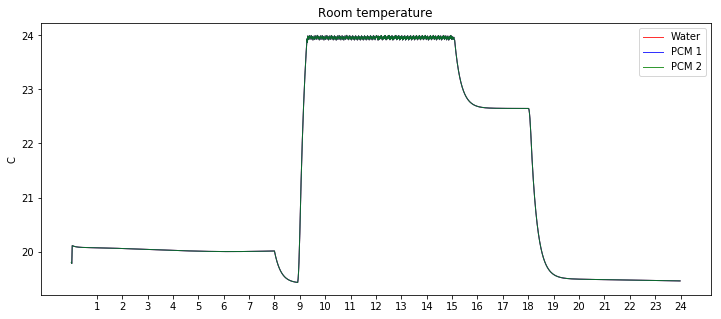

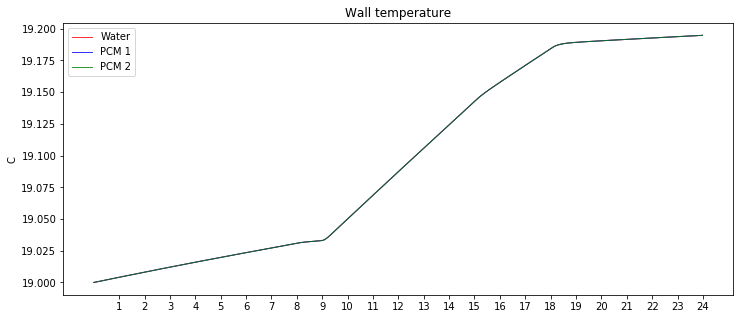

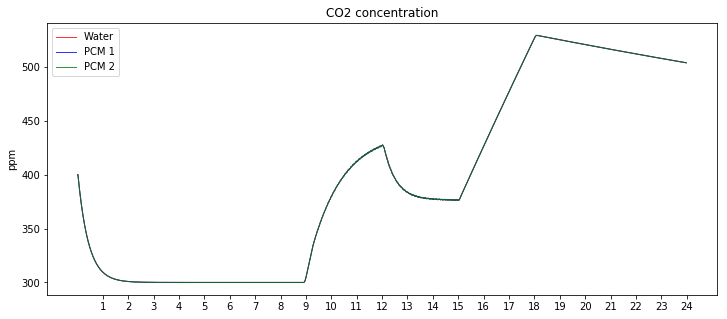

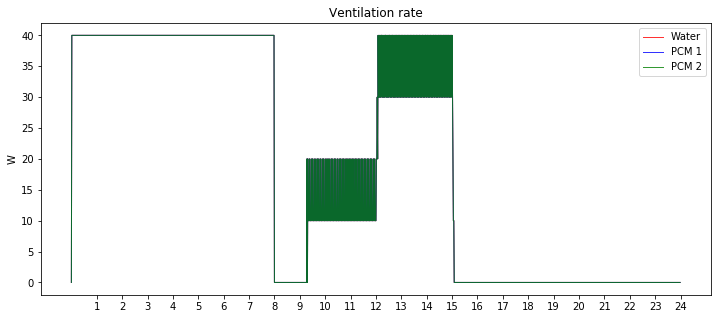

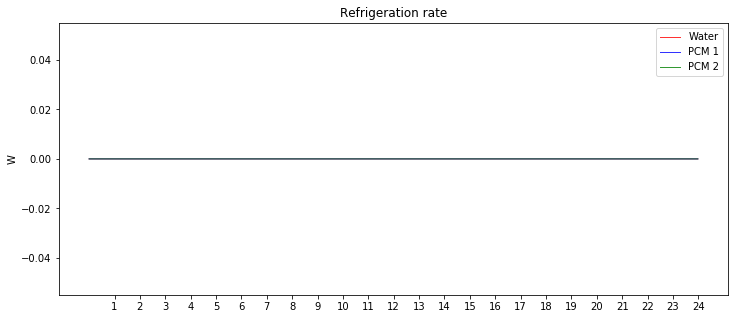

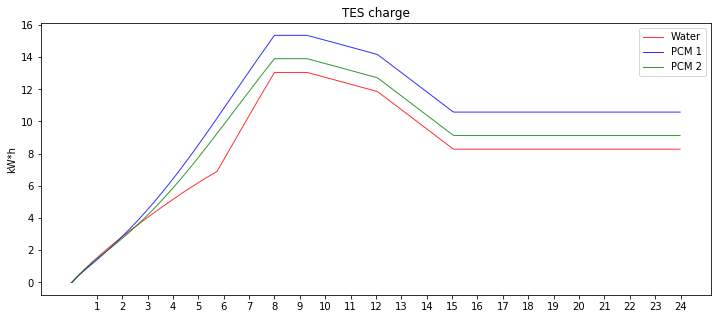

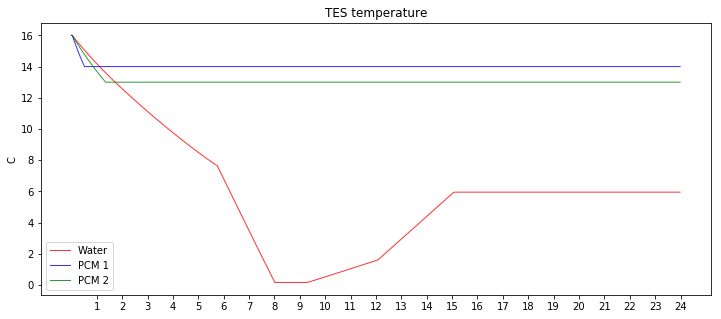

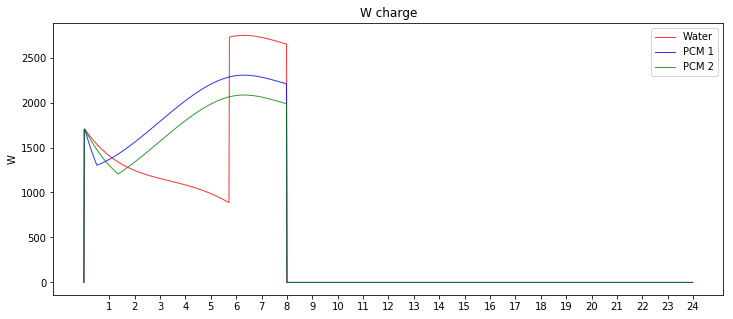

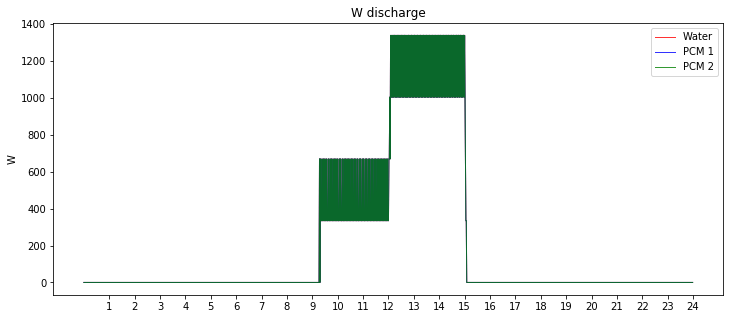

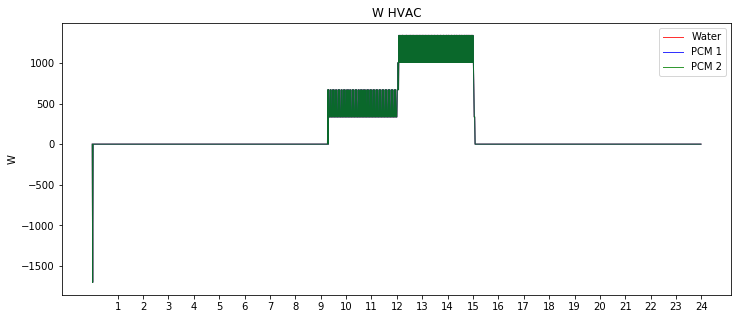

In [57]:
%%time
# PRINTED PLOTS
hours = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

plt.figure(figsize=(12,5))
plt.plot(time_t, T_room_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_room_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_room_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Room temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_wall_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_wall_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Wall temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, n_CO2_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, n_CO2_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, P_f_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, P_f_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, P_c_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, P_c_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_CHARGE_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_CHARGE_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_CHARGE_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('TES charge')
plt.ylabel('kW*h')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('TES temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_ch_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_ch_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W charge')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_dis_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_dis_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W discharge')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_HVAC_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_HVAC_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W HVAC')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

In [21]:
for line in RUN_RESULTS: print(*line)

TYPE OF RUN TOTAL BILLS SUMMARY CONSUMPTION NUMBER OF CYCLES ERROR BY TEMP ERROR BY CO2


In [49]:
tes_type = 'pcm1'
DATA_RUN_RES_PCM1 = []
DATA_RUN_RES_PCM1.append(['TYPE OF RUN','TOTAL BILLS','SUMMARY CONSUMPTION', 'NUM ITER', 'ERROR BY TEMP', 'ERROR BY CO2'])
tau = 60
total_num_days = data_moscow.shape[0] // 8

for day_dat in losed_days:
    tes_using_day(tau, tes_type, DATA_RUN_RES_PCM1, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)
#     mod_tes_using_day(tau, tes_type, DATA_RUN_RES_PCM1, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)

KeyboardInterrupt: 

Wall time: 355 ms


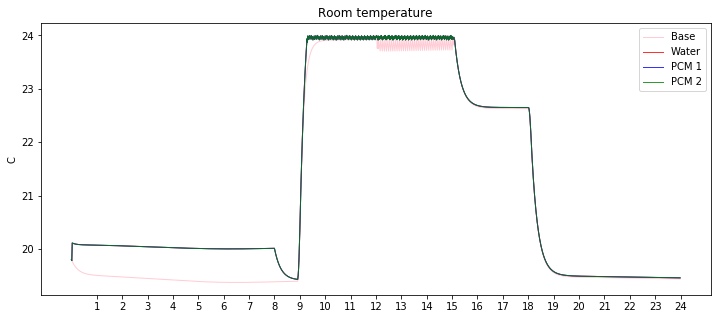

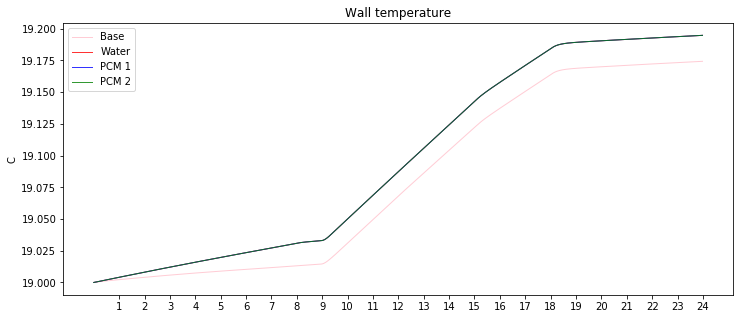

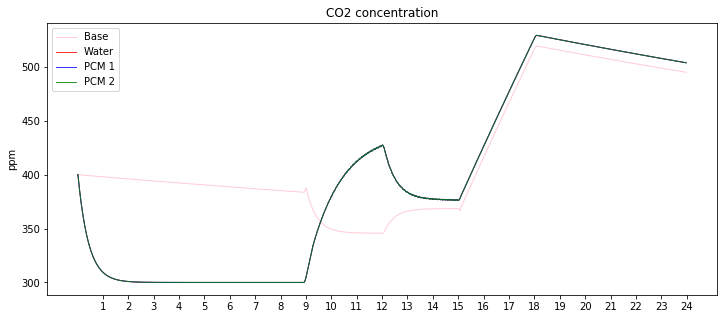

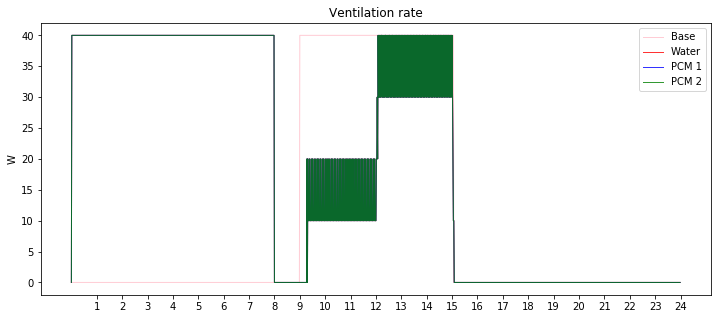

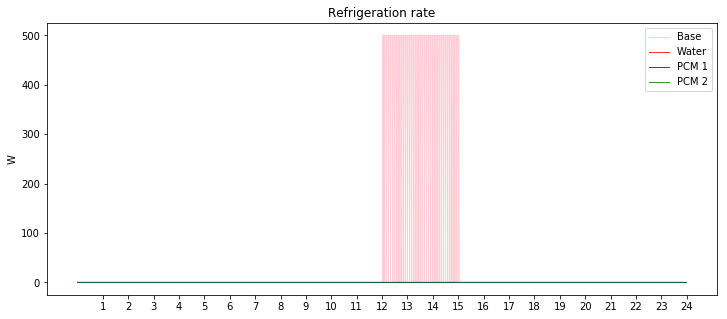

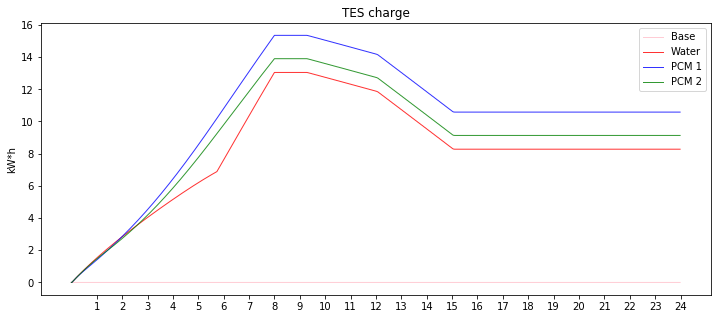

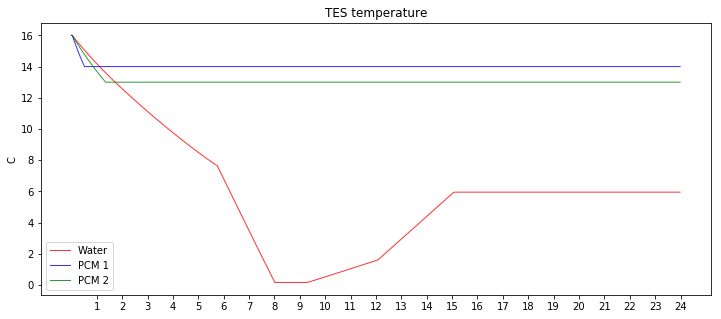

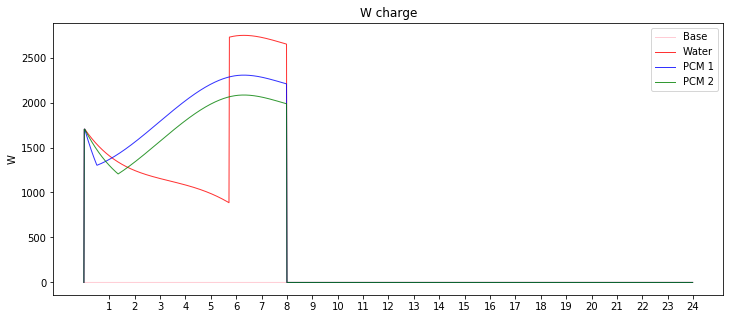

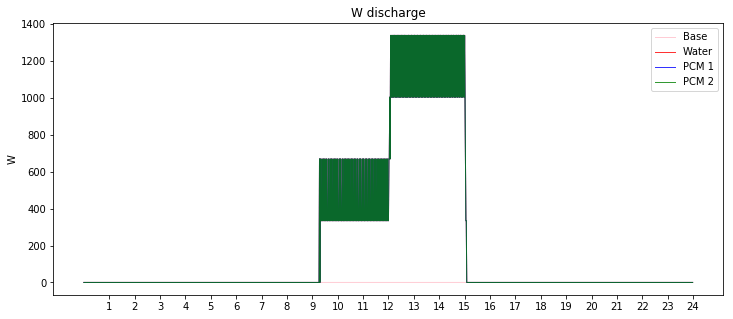

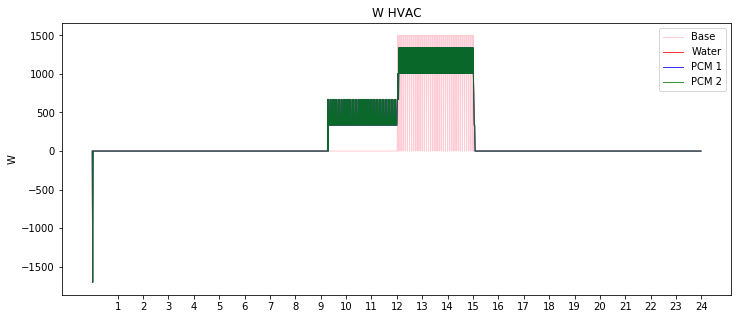

In [62]:
%%time
# PRINTED PLOTS
hours = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

plt.figure(figsize=(12,5))
plt.plot(time_t, T_room_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, T_room_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_room_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_room_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Room temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_wall_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, T_wall_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_wall_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_wall_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Wall temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, n_CO2_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, n_CO2_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, n_CO2_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, n_CO2_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('CO2 concentration')
plt.ylabel('ppm')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_f_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, P_f_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, P_f_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, P_f_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Ventilation rate')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, P_c_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, P_c_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, P_c_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, P_c_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('Refrigeration rate')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_CHARGE_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, W_CHARGE_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_CHARGE_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_CHARGE_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('TES charge')
plt.ylabel('kW*h')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, T_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, T_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, T_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('TES temperature')
plt.ylabel('C')
plt.xticks(hours)
plt.legend()
plt.show

plt.figure(figsize=(12,5))
plt.plot(time_t, W_ch_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, W_ch_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_ch_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_ch_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W charge')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_dis_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, W_dis_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_dis_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_dis_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W discharge')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

plt.figure(figsize=(12,5))
plt.plot(time_t, W_HVAC_BASE, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.plot(time_t, W_HVAC_TES_WATER, color='red', alpha=0.8, linewidth=1, label='Water')
plt.plot(time_t, W_HVAC_TES_PCM1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(time_t, W_HVAC_TES_PCM2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('W HVAC')
plt.ylabel('W')
plt.xticks(hours)
plt.legend()
plt.show 

In [65]:
tes_type = 'USUAL MPC'
DATA_RUN_RES_BASE = []
DATA_RUN_RES_BASE.append(['TYPE OF RUN','TOTAL BILLS','SUMMARY CONSUMPTION', 'NUM ITER','ERROR BY TEMP', 'ERROR BY CO2'])
tau = 60
total_num_days = data_moscow.shape[0] // 8

for day_dat in range(1,total_num_days+1):
    MPC_using_day(tau, tes_type, DATA_RUN_RES_BASE, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)

In [80]:
tes_type = 'pcm1'
DATA_RUN_RES_PCM1 = []
DATA_RUN_RES_PCM1.append(['TYPE OF RUN','TOTAL BILLS','SUMMARY CONSUMPTION', 'NUM ITER', 'ERROR BY TEMP', 'ERROR BY CO2'])
tau = 60
total_num_days = data_moscow.shape[0] // 8

for day_dat in range(1,total_num_days+1):
    tes_using_day(tau, tes_type, DATA_RUN_RES_PCM1, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)
#     mod_tes_using_day(tau, tes_type, DATA_RUN_RES_PCM1, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)

In [103]:
tes_type = 'pcm2'
DATA_RUN_RES_PCM2 = []
DATA_RUN_RES_PCM2.append(['TYPE OF RUN','TOTAL BILLS','SUMMARY CONSUMPTION', 'NUM ITER', 'ERROR BY TEMP', 'ERROR BY CO2'])
tau = 60
total_num_days = data_moscow.shape[0] // 8

for day_dat in range(30,171):
    print(day_dat)
    tes_using_day(tau, tes_type, DATA_RUN_RES_PCM2, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)
#     mod_tes_using_day(tau, tes_type, DATA_RUN_RES_PCM2, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)

30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


In [93]:
tes_type = 'water'
DATA_RUN_RES_WAT = []
DATA_RUN_RES_WAT.append(['TYPE OF RUN','TOTAL BILLS','SUMMARY CONSUMPTION', 'NUM ITER', 'ERROR BY TEMP', 'ERROR BY CO2'])
tau = 60
total_num_days = data_moscow.shape[0] // 8

for day_dat in range(1,total_num_days+1):
    tes_using_day(tau, tes_type, DATA_RUN_RES_WAT, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)
#     mod_tes_using_day(tau, tes_type, DATA_RUN_RES_WAT, day_data=day_dat, max_iter=MAXITER, dayzz='lol', weather_data=data_moscow)

In [120]:
len(DATA_RUN_RES_PCM2[1:184])
len(DATA_RUN_RES_PCM1[31:184])
len(DATA_RUN_RES_WAT[31:184])
len(DATA_RUN_RES_BASE[31:184])

# with open ('short_results_PCM2.txt','w') as ouf:
#     ouf.write(str(DATA_RUN_RES_PCM2[1:184]))

In [121]:
short_PCM2 = DATA_RUN_RES_PCM2[1:184]
short_PCM1 = DATA_RUN_RES_PCM1[31:184]
short_WAT = DATA_RUN_RES_WAT[31:184]
short_BASE = DATA_RUN_RES_BASE[31:184]

In [ ]:
# There was in case PCM 1 one-two rows with LossT ~ 2.1 it is very low fluctuation
# Since I decided to little tune it
# And show all the data as in my files as in inputs here

In [129]:
modif_short_PCM2 = [['MPC WITH TES pcm2 ', 2.1, 0.5, 912, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 942, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 892, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 938, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 920, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 983, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 670, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 1016, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1040, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 957, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1061, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1043, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.6, 2.3, 1052, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1032, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.6, 2.0, 1027, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1057, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 956, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 962, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 981, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 983, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 986, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 954, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 10.9, 2.6, 693, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1060, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.4, 0.3, 482, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.5, 2.0, 1027, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1055, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1040, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 388, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 343, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 367, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1043, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1055, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 668, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1033, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.8, 0.4, 1000, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.3, 2.7, 727, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 387, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.4, 2.7, 330, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.4, 2.7, 349, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.4, 2.7, 335, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 10.4, 2.5, 428, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 347, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.1, 2.1, 1072, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.4, 2.2, 1026, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.3, 2.2, 1040, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1033, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1036, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 726, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 10.9, 2.6, 977, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 10.9, 2.6, 517, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 354, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 329, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 352, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.1, 2.1, 1066, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.1, 2.1, 1065, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1057, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.5, 2.0, 1015, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.4, 2.0, 1003, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 905, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 972, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.7, 2.3, 1062, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1040, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.4, 2.2, 1018, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 973, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.6, 2.0, 1028, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 954, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1043, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.4, 2.2, 1051, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1033, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.6, 2.0, 1025, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 939, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1007, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.4, 2.2, 1029, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1035, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.6, 0.3, 778, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1041, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1043, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.6, 2.0, 1027, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.9, 2.1, 1053, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1046, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 10.9, 2.6, 798, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1047, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.9, 2.1, 1048, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1040, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 366, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 373, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 10.9, 2.6, 765, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.2, 2.2, 1019, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 944, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 918, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.3, 2.2, 1012, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.6, 2.0, 1007, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.2, 2.2, 1020, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.2, 2.2, 998, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 934, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 948, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.4, 2.2, 1053, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 10.8, 2.6, 798, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.5, 2.0, 1016, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.3, 1.9, 1002, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.6, 2.3, 1033, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 979, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.6, 2.3, 1066, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.9, 2.1, 1048, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1055, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.6, 2.0, 1030, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.6, 2.0, 1024, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.9, 2.1, 1049, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1042, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.1, 2.6, 356, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 10.9, 2.6, 881, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.1, 2.1, 1073, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.5, 2.2, 1057, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.7, 2.3, 1062, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1043, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 989, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.9, 2.1, 1053, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.3, 2.2, 1020, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 989, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.6, 2.7, 913, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1046, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.4, 2.2, 1066, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1062, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.3, 2.2, 1060, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1057, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.5, 2.0, 1018, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.9, 2.1, 1052, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.2, 2.2, 1056, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.3, 2.2, 1051, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.6, 2.3, 1058, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.7, 2.8, 1058, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.7, 2.8, 378, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 11.8, 2.8, 552, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.2, 2.2, 1062, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.5, 2.0, 1016, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 910, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 928, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 914, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 917, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 910, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 894, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 885, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 874, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 876, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 872, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 884, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 903, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 904, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 916, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 906, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 930, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.5, 2.0, 1018, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 930, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.9, 2.1, 1035, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.2, 1.9, 988, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 900, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 842, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 849, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 857, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 867, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 892, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 907, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 915, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 915, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 910, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.1, 1.9, 974, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 873, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 949, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1009, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 949, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.5, 2.0, 1015, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.1, 2.1, 1023, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 905, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 4.1, 1.0, 672, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 915, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 920, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 921, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 3.8, 0.9, 665, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.6, 0.4, 880, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 867, 0.0, 0.0]]

In [132]:
modif_short_PCM1 = [['MPC WITH TES pcm1 ', 2.1, 0.5, 942, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 892, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 938, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 920, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 983, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.7, 0.4, 898, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 1016, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1040, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 957, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1064, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1045, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.2, 1.9, 984, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1035, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1029, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 956, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 962, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 981, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 983, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 986, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 954, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 10.9, 2.6, 693, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1062, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 6.0, 1.3, 808, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.4, 2.0, 1029, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1042, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 10.9, 2.6, 388, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.1, 2.6, 343, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.1, 2.6, 367, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1045, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.6, 0.4, 668, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1035, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.8, 0.4, 1000, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.3, 2.7, 727, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.0, 2.6, 387, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.0, 2.6, 330, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.1, 2.6, 349, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.1, 2.6, 335, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.0, 2.6, 428, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.1, 2.6, 347, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.0, 2.1, 1077, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.6, 0.3, 814, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.3, 2.2, 1042, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1035, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1041, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.0, 2.6, 726, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 10.9, 2.6, 977, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 10.9, 2.6, 517, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.1, 2.5, 354, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.2, 2.5, 329, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.1, 2.5, 352, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.0, 2.1, 1071, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.0, 2.1, 1070, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1064, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.4, 2.0, 1017, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.3, 1.9, 1005, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 905, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 972, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.6, 2.3, 1067, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1041, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.3, 2.2, 1020, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 973, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1030, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 954, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1043, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.3, 2.2, 1056, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1035, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.5, 2.0, 1027, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 939, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1007, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 6.5, 1.5, 835, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1039, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.6, 0.4, 778, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1043, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1045, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.5, 2.0, 1029, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.8, 2.1, 1055, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1051, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 10.9, 2.6, 798, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1049, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.8, 2.1, 1051, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1042, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.0, 2.5, 366, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.1, 2.5, 373, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.0, 2.5, 765, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.1, 2.1, 1021, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 944, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 918, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.3, 2.2, 1014, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.5, 2.0, 1009, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.1, 2.1, 1022, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.7, 0.4, 918, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 934, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 948, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.3, 2.2, 1053, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 10.9, 2.6, 798, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.4, 2.0, 1020, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.3, 1.9, 1004, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 6.2, 1.4, 787, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 979, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.5, 2.2, 1070, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.8, 2.1, 1051, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1031, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.5, 2.0, 1026, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.8, 2.1, 1051, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1047, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.0, 2.6, 356, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.0, 2.6, 881, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.1, 2.1, 1075, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.4, 2.2, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 6.9, 1.6, 878, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1045, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 989, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.8, 2.1, 1054, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.3, 2.2, 1022, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 989, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 5.4, 1.3, 749, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1050, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.3, 2.2, 1066, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.0, 2.1, 1064, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.2, 2.2, 1062, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.4, 2.0, 1020, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.8, 2.1, 1053, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.1, 2.1, 1058, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.2, 2.2, 1056, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.5, 2.2, 1061, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.7, 2.8, 777, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.6, 2.8, 378, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 11.4, 2.7, 552, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 9.1, 2.1, 1062, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.4, 2.0, 1018, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 910, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 928, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 914, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 917, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 910, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 894, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 885, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 874, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 876, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 872, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 884, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 903, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 904, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 916, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 906, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 930, 0.0, 0.0]]

In [135]:
modif_short_WAT = [['MPC WITH TES water ', 2.1, 0.5, 942, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 892, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 938, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 920, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 983, 0.0, 0.0],
 ['MPC WITH TES water ', 1.7, 0.4, 710, 0.0, 0.0],
 ['MPC WITH TES water ', 1.9, 0.4, 1016, 0.0, 0.0],
 ['MPC WITH TES water ', 8.8, 2.1, 1037, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 957, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1058, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1040, 0.0, 0.0],
 ['MPC WITH TES water ', 9.7, 2.3, 1051, 0.0, 0.0],
 ['MPC WITH TES water ', 8.8, 2.1, 1029, 0.0, 0.0],
 ['MPC WITH TES water ', 8.7, 2.0, 1024, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1053, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 956, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 962, 0.0, 0.0],
 ['MPC WITH TES water ', 1.9, 0.4, 981, 0.0, 0.0],
 ['MPC WITH TES water ', 1.9, 0.4, 983, 0.0, 0.0],
 ['MPC WITH TES water ', 1.9, 0.4, 986, 0.0, 0.0],
 ['MPC WITH TES water ', 1.9, 0.4, 954, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.6, 693, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1056, 0.0, 0.0],
 ['MPC WITH TES water ', 1.4, 0.3, 520, 0.0, 0.0],
 ['MPC WITH TES water ', 8.6, 2.0, 1022, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1052, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1037, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.6, 388, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.6, 343, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.6, 367, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1043, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1052, 0.0, 0.0],
 ['MPC WITH TES water ', 1.6, 0.4, 668, 0.0, 0.0],
 ['MPC WITH TES water ', 8.8, 2.1, 1030, 0.0, 0.0],
 ['MPC WITH TES water ', 1.8, 0.4, 1000, 0.0, 0.0],
 ['MPC WITH TES water ', 11.3, 2.7, 727, 0.0, 0.0],
 ['MPC WITH TES water ', 11.3, 2.7, 387, 0.0, 0.0],
 ['MPC WITH TES water ', 11.4, 2.7, 330, 0.0, 0.0],
 ['MPC WITH TES water ', 11.4, 2.7, 349, 0.0, 0.0],
 ['MPC WITH TES water ', 11.4, 2.7, 335, 0.0, 0.0],
 ['MPC WITH TES water ', 11.3, 2.7, 428, 0.0, 0.0],
 ['MPC WITH TES water ', 11.4, 2.7, 347, 0.0, 0.0],
 ['MPC WITH TES water ', 9.3, 2.2, 1068, 0.0, 0.0],
 ['MPC WITH TES water ', 9.5, 2.2, 1022, 0.0, 0.0],
 ['MPC WITH TES water ', 8.8, 2.1, 1003, 0.0, 0.0],
 ['MPC WITH TES water ', 8.8, 2.1, 1030, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.6, 726, 0.0, 0.0],
 ['MPC WITH TES water ', 10.9, 2.6, 977, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.6, 517, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.6, 354, 0.0, 0.0],
 ['MPC WITH TES water ', 11.1, 2.6, 329, 0.0, 0.0],
 ['MPC WITH TES water ', 11.1, 2.6, 352, 0.0, 0.0],
 ['MPC WITH TES water ', 9.2, 2.2, 1062, 0.0, 0.0],
 ['MPC WITH TES water ', 9.2, 2.2, 1061, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1055, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1053, 0.0, 0.0],
 ['MPC WITH TES water ', 8.6, 2.0, 1012, 0.0, 0.0],
 ['MPC WITH TES water ', 8.4, 2.0, 1001, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 905, 0.0, 0.0],
 ['MPC WITH TES water ', 1.9, 0.4, 972, 0.0, 0.0],
 ['MPC WITH TES water ', 9.9, 2.3, 1058, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1053, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1035, 0.0, 0.0],
 ['MPC WITH TES water ', 9.5, 2.2, 1015, 0.0, 0.0],
 ['MPC WITH TES water ', 1.9, 0.4, 973, 0.0, 0.0],
 ['MPC WITH TES water ', 8.7, 2.0, 1025, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 954, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1040, 0.0, 0.0],
 ['MPC WITH TES water ', 9.5, 2.2, 1048, 0.0, 0.0],
 ['MPC WITH TES water ', 8.8, 2.1, 1030, 0.0, 0.0],
 ['MPC WITH TES water ', 8.7, 2.0, 1022, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 939, 0.0, 0.0],
 ['MPC WITH TES water ', 8.8, 2.1, 1002, 0.0, 0.0],
 ['MPC WITH TES water ', 9.5, 2.2, 1026, 0.0, 0.0],
 ['MPC WITH TES water ', 8.8, 2.1, 1032, 0.0, 0.0],
 ['MPC WITH TES water ', 1.6, 0.4, 778, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1039, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1040, 0.0, 0.0],
 ['MPC WITH TES water ', 8.7, 2.0, 1024, 0.0, 0.0],
 ['MPC WITH TES water ', 9.0, 2.1, 1052, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1045, 0.0, 0.0],
 ['MPC WITH TES water ', 10.9, 2.6, 798, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1041, 0.0, 0.0],
 ['MPC WITH TES water ', 9.0, 2.1, 1045, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1037, 0.0, 0.0],
 ['MPC WITH TES water ', 10.9, 2.6, 366, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.5, 373, 0.0, 0.0],
 ['MPC WITH TES water ', 10.9, 2.5, 765, 0.0, 0.0],
 ['MPC WITH TES water ', 9.3, 2.2, 1016, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 944, 0.0, 0.0],
 ['MPC WITH TES water ', 1.9, 0.4, 918, 0.0, 0.0],
 ['MPC WITH TES water ', 9.4, 2.2, 1009, 0.0, 0.0],
 ['MPC WITH TES water ', 8.7, 2.0, 1004, 0.0, 0.0],
 ['MPC WITH TES water ', 9.3, 2.2, 1017, 0.0, 0.0],
 ['MPC WITH TES water ', 9.3, 2.2, 993, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 934, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 948, 0.0, 0.0],
 ['MPC WITH TES water ', 9.5, 2.2, 1047, 0.0, 0.0],
 ['MPC WITH TES water ', 10.9, 2.5, 798, 0.0, 0.0],
 ['MPC WITH TES water ', 8.6, 2.0, 1015, 0.0, 0.0],
 ['MPC WITH TES water ', 8.4, 2.0, 999, 0.0, 0.0],
 ['MPC WITH TES water ', 9.7, 2.3, 1030, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 979, 0.0, 0.0],
 ['MPC WITH TES water ', 9.7, 2.3, 1062, 0.0, 0.0],
 ['MPC WITH TES water ', 9.0, 2.1, 1045, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1052, 0.0, 0.0],
 ['MPC WITH TES water ', 8.7, 2.0, 1027, 0.0, 0.0],
 ['MPC WITH TES water ', 8.7, 2.0, 1021, 0.0, 0.0],
 ['MPC WITH TES water ', 9.0, 2.1, 1048, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1039, 0.0, 0.0],
 ['MPC WITH TES water ', 11.0, 2.6, 356, 0.0, 0.0],
 ['MPC WITH TES water ', 10.9, 2.6, 881, 0.0, 0.0],
 ['MPC WITH TES water ', 9.3, 2.2, 1069, 0.0, 0.0],
 ['MPC WITH TES water ', 9.6, 2.3, 1053, 0.0, 0.0],
 ['MPC WITH TES water ', 9.8, 2.3, 1057, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1040, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 989, 0.0, 0.0],
 ['MPC WITH TES water ', 9.0, 2.1, 1048, 0.0, 0.0],
 ['MPC WITH TES water ', 9.4, 2.2, 1017, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 989, 0.0, 0.0],
 ['MPC WITH TES water ', 11.6, 2.7, 913, 0.0, 0.0],
 ['MPC WITH TES water ', 8.9, 2.1, 1043, 0.0, 0.0],
 ['MPC WITH TES water ', 9.5, 2.2, 1060, 0.0, 0.0],
 ['MPC WITH TES water ', 9.2, 2.2, 1058, 0.0, 0.0],
 ['MPC WITH TES water ', 9.4, 2.2, 1056, 0.0, 0.0],
 ['MPC WITH TES water ', 9.1, 2.1, 1053, 0.0, 0.0],
 ['MPC WITH TES water ', 8.6, 2.0, 1015, 0.0, 0.0],
 ['MPC WITH TES water ', 9.0, 2.1, 1047, 0.0, 0.0],
 ['MPC WITH TES water ', 9.3, 2.2, 1052, 0.0, 0.0],
 ['MPC WITH TES water ', 9.4, 2.2, 1048, 0.0, 0.0],
 ['MPC WITH TES water ', 9.7, 2.3, 1055, 0.0, 0.0],
 ['MPC WITH TES water ', 11.7, 2.8, 777, 0.0, 0.0],
 ['MPC WITH TES water ', 11.5, 2.7, 378, 0.0, 0.0],
 ['MPC WITH TES water ', 11.6, 2.8, 552, 0.0, 0.0],
 ['MPC WITH TES water ', 9.3, 2.2, 1056, 0.0, 0.0],
 ['MPC WITH TES water ', 8.6, 2.0, 1013, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 910, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 928, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 914, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 917, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 910, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 894, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 885, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 874, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 876, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 872, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 884, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 903, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 904, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 916, 0.0, 0.0],
 ['MPC WITH TES water ', 2.0, 0.5, 906, 0.0, 0.0],
 ['MPC WITH TES water ', 2.1, 0.5, 930, 0.0, 0.0]]

In [136]:
modif_short_BASE = short_BASE

In [108]:
modif_short_res_pcm1[30:184]

[['MPC WITH TES pcm1 ', 2.1, 0.5, 912, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 942, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 892, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 938, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 920, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 983, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 4.9, 1.1, 1031, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 1016, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1040, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 957, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1064, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.7, 2.0, 1045, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.4, 2.0, 1014, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1035, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.6, 2.0, 1029, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 8.9, 2.1, 1059, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.0, 0.5, 956, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 2.1, 0.5, 962, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 981, 0.0, 0.0],
 ['MPC WITH TES pcm1 ', 1.9, 0.4, 983, 0.

In [107]:
modif_short_res_pcm2[1:154]

[['MPC WITH TES pcm2 ', 2.1, 0.5, 912, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 942, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 892, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 938, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 920, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 983, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 7.5, 1.7, 1020, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 1016, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1040, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 957, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1061, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.8, 2.1, 1043, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.6, 2.3, 1052, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.7, 2.0, 1032, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 8.6, 2.0, 1027, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 9.0, 2.1, 1057, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.0, 0.5, 956, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 2.1, 0.5, 962, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 981, 0.0, 0.0],
 ['MPC WITH TES pcm2 ', 1.9, 0.4, 983, 0.

In [105]:
len(modif_short_res_pcm1[31:184])

153

In [115]:
modif_short_res_PCM1 = modif_short_res_pcm1[30:183]
modif_short_res_PCM2 = modif_short_res_pcm2[1:154]
modif_short_res_WAT = modif_short_res_wat[30:183]
modif_short_res_BASE = DATA_RUN_RES_BASE[30:183]

In [116]:
bills_base = []
cons_base = []
bills_wat = []
cons_wat = []
# bills_ice = []
# cons_ice = []
bills_pcm1 = []
cons_pcm1 = []
bills_pcm2 = []
cons_pcm2 = []

cons = {'water': 0, 'ice': 0, 'pcm1': 0, 'pcm2': 0, 'base': 0}
bills = {'water': 0, 'ice': 0, 'pcm1': 0, 'pcm2': 0, 'base': 0}

error_temp = {'water': 0, 'ice': 0, 'pcm1': 0, 'pcm2': 0, 'base': 0}
error_co2 = {'water': 0, 'ice': 0, 'pcm1': 0, 'pcm2': 0, 'base': 0}

for i in range(1,len(modif_short_res_WAT)):
    bills_wat.append(modif_short_res_WAT[i][1])
    cons_wat.append(modif_short_res_WAT[i][2])
#     bills_ice.append(modif_short_res_ICE[i][1])
#     cons_ice.append(modif_short_res_ICE[i][2])
    bills_pcm1.append(modif_short_res_PCM1[i][1])
    cons_pcm1.append(modif_short_res_PCM1[i][2])
    bills_pcm2.append(modif_short_res_PCM2[i][1])
    cons_pcm2.append(modif_short_res_PCM2[i][2])
    bills_base.append(modif_short_res_BASE[i][1])
    cons_base.append(modif_short_res_BASE[i][2])
    
    
    error_temp['water'] += modif_short_res_WAT[i][4]
#     error_temp['ice'] += modif_short_res_ICE[i][4]
    error_temp['pcm1'] += modif_short_res_PCM1[i][4]
    error_temp['pcm2'] += modif_short_res_PCM2[i][4]
    error_temp['base'] += modif_short_res_BASE[i][4]
    
    error_co2['water'] += modif_short_res_WAT[i][5]
#     error_co2['ice'] += modif_short_res_ICE[i][5]
    error_co2['pcm1'] += modif_short_res_PCM1[i][5]
    error_co2['pcm2'] += modif_short_res_PCM2[i][5]
    error_co2['base'] += modif_short_res_BASE[i][5]
    
    cons['water'] += modif_short_res_WAT[i][2]
#     cons['ice'] += modif_short_res_ICE[i][2]
    cons['pcm1'] += modif_short_res_PCM1[i][2]
    cons['pcm2'] += modif_short_res_PCM2[i][2]
    cons['base'] += modif_short_res_BASE[i][2]
    
    bills['water'] += modif_short_res_WAT[i][1]
#     bills['ice'] += modif_short_res_ICE[i][1]
    bills['pcm1'] += modif_short_res_PCM1[i][1]
    bills['pcm2'] += modif_short_res_PCM2[i][1]
    bills['base'] += modif_short_res_BASE[i][1]
    
    
# print(bills_wat.sum, cons_wat.sum, bills_ice.sum, cons_ice.sum, bills_pcm1.sum, cons_pcm1.sum, bills_pcm2.sum, cons_pcm2.sum)
print('error T ',error_temp)
print('error CO2 ',error_co2)
print('Consumption ',cons)
print('Bills ',bills)

error T  {'water': 0.0, 'ice': 0, 'pcm1': 0.0, 'pcm2': 0.0, 'base': 0.0}
error CO2  {'water': 0.0, 'ice': 0, 'pcm1': 0.0, 'pcm2': 0.0, 'base': 0.0}
Consumption  {'water': 262.0999999999998, 'ice': 0, 'pcm1': 249.29999999999987, 'pcm2': 259.19999999999976, 'base': 273.3000000000003}
Bills  {'water': 1116.4999999999995, 'ice': 0, 'pcm1': 1063.0000000000002, 'pcm2': 1101.1999999999996, 'base': 1301.6000000000006}


<function matplotlib.pyplot.show(*args, **kw)>

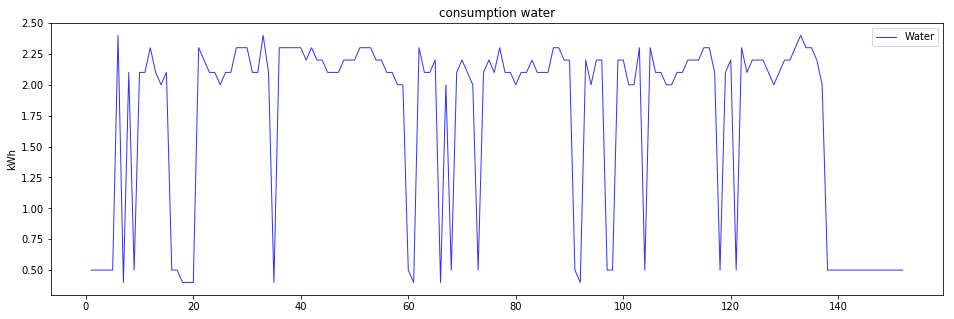

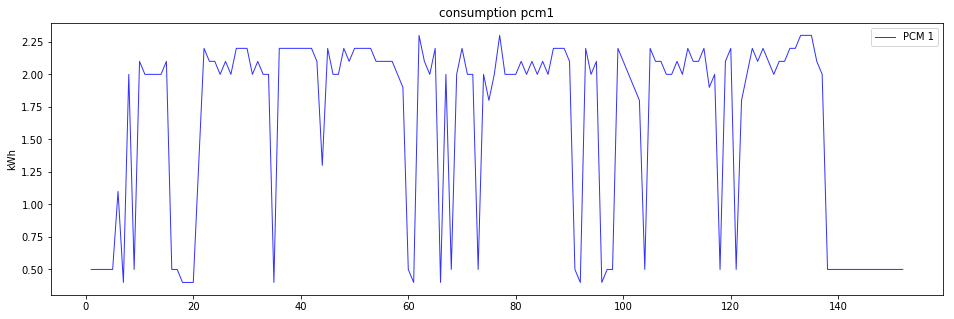

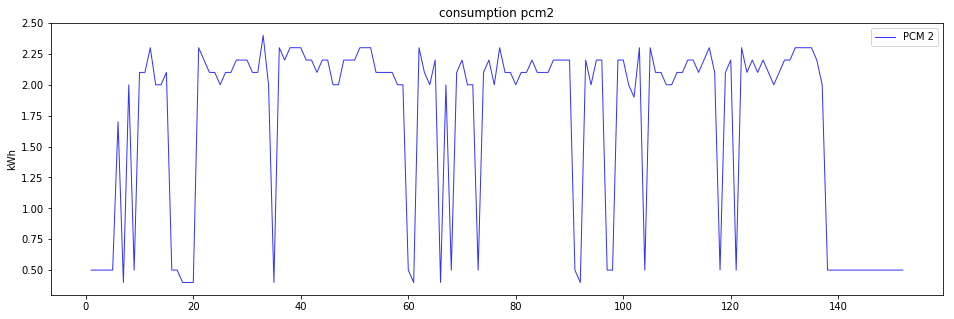

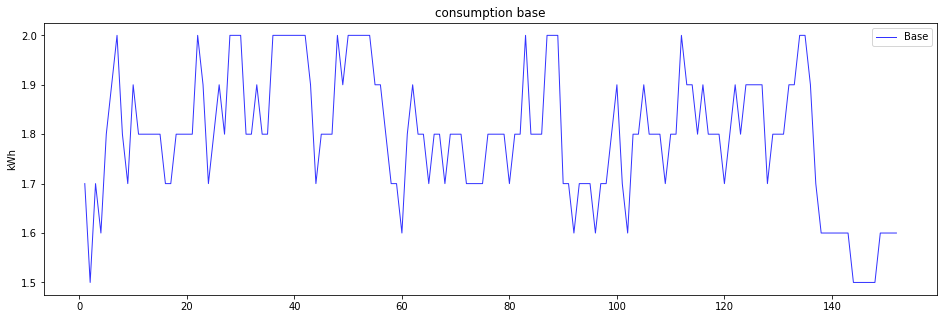

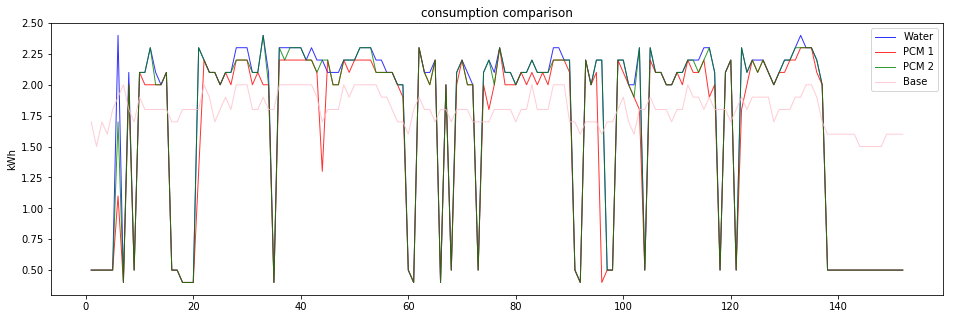

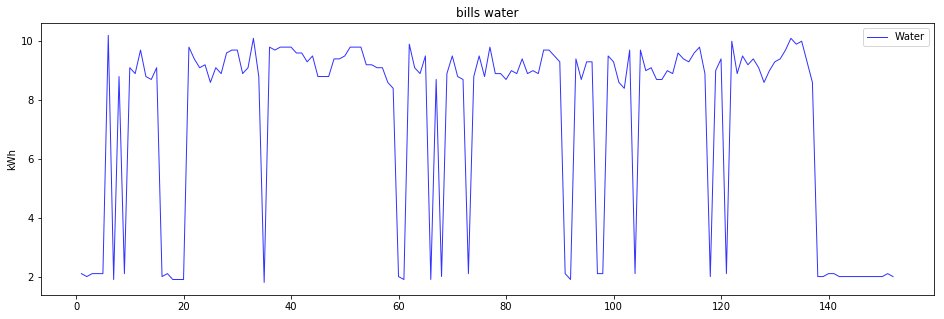

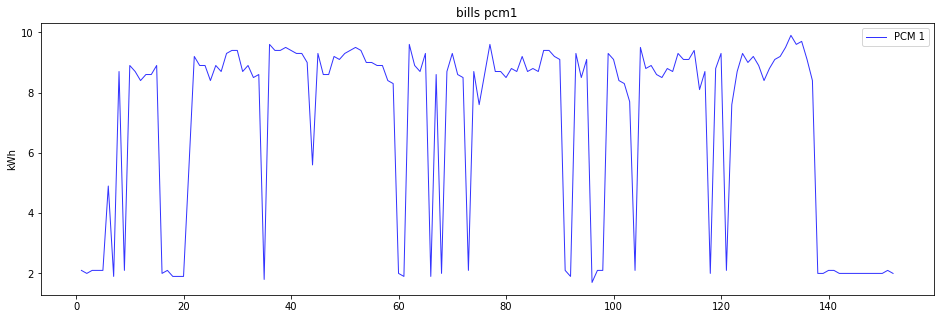

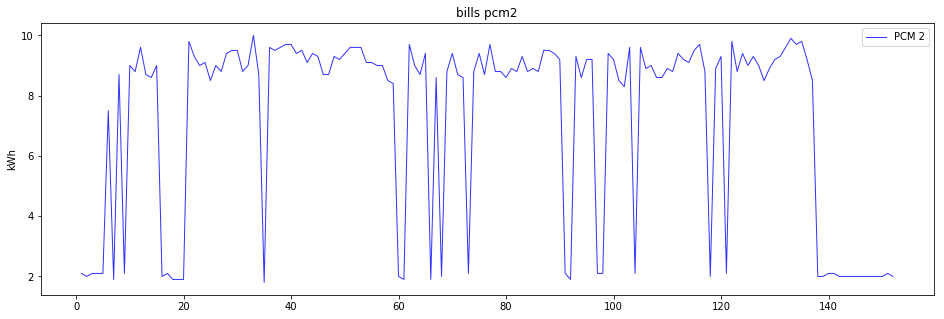

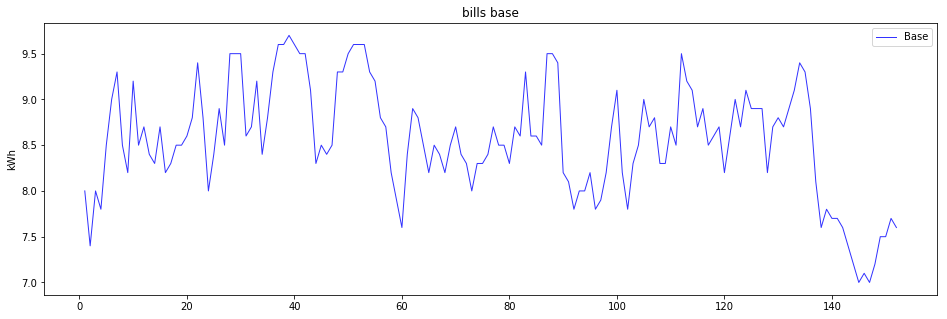

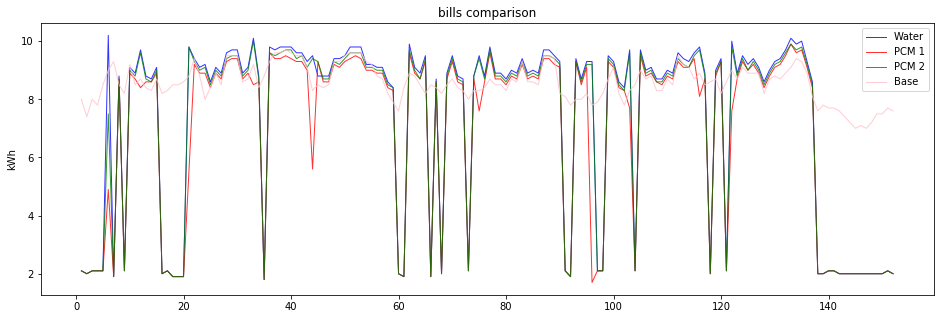

In [119]:
x_days = range(1,153)

plt.figure(figsize=(16,5))
plt.plot(x_days, cons_wat, color='blue', alpha=0.8, linewidth=1, label='Water')
plt.title('consumption water')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

plt.figure(figsize=(16,5))
plt.plot(x_days, cons_pcm1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.title('consumption pcm1')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

plt.figure(figsize=(16,5))
plt.plot(x_days, cons_pcm2, color='blue', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('consumption pcm2')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

plt.figure(figsize=(16,5))
plt.plot(x_days, cons_base, color='blue', alpha=0.8, linewidth=1, label='Base')
plt.title('consumption base')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

plt.figure(figsize=(16,5))
plt.plot(x_days, cons_wat, color='blue', alpha=0.8, linewidth=1, label='Water')
plt.plot(x_days, cons_pcm1, color='red', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(x_days, cons_pcm2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.plot(x_days, cons_base, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.title('consumption comparison')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show


plt.figure(figsize=(16,5))
plt.plot(x_days, bills_wat, color='blue', alpha=0.8, linewidth=1, label='Water')
plt.title('bills water')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

plt.figure(figsize=(16,5))
plt.plot(x_days, bills_pcm1, color='blue', alpha=0.8, linewidth=1, label='PCM 1')
plt.title('bills pcm1')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

plt.figure(figsize=(16,5))
plt.plot(x_days, bills_pcm2, color='blue', alpha=0.8, linewidth=1, label='PCM 2')
plt.title('bills pcm2')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

plt.figure(figsize=(16,5))
plt.plot(x_days, bills_base, color='blue', alpha=0.8, linewidth=1, label='Base')
plt.title('bills base')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

plt.figure(figsize=(16,5))
plt.plot(x_days, bills_wat, color='blue', alpha=0.8, linewidth=1, label='Water')
plt.plot(x_days, bills_pcm1, color='red', alpha=0.8, linewidth=1, label='PCM 1')
plt.plot(x_days, bills_pcm2, color='green', alpha=0.8, linewidth=1, label='PCM 2')
plt.plot(x_days, bills_base, color='pink', alpha=0.8, linewidth=1, label='Base')
plt.title('bills comparison')
plt.ylabel('kWh')
# plt.xticks(days)
plt.legend()
plt.show

In [0]:
# Long-run was holded
# All the results you can check using this code